In [21]:
import os
os.environ["PATH"] = "/usr/local/cuda-11.8/bin:{}".format(os.environ["PATH"])
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-11.8/lib64"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import sys
sys.path.append("/home/yang_liu/python_workspace/gaussian-splatting-lightning")

import torch
import numpy as np
import random

from internal.utils.ssim import ssim
from matplotlib import pyplot as plt
from matplotlib import colors
from gsplat.rasterize import rasterize_gaussians
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.dataparsers.colmap_dataparser import ColmapParams, ColmapDataParser
from internal.dataparsers.colmap_block_dataparser import ColmapBlockParams, ColmapBlockDataParser
from internal.renderers.vanilla_renderer import VanillaRenderer
from internal.renderers.vanilla_trim_renderer import VanillaTrimRenderer
from internal.utils.sh_utils import eval_gaussian_model_sh

torch.set_grad_enabled(False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# load model and dataset
load_from_1 = "../outputs/citygs_flatten_smbu_coarse/checkpoints/epoch=60-step=30000.ckpt"
model_1, renderer_1, _ = GaussianModelLoader.initialize_simplified_model_from_checkpoint(load_from_1, device="cuda")
if isinstance(renderer_1, VanillaTrimRenderer):
    model_1._scaling = torch.cat((torch.ones_like(model_1._scaling[:, :1]) * 1e-8, model_1._scaling[:, [-2, -1]]), dim=1)
    flatten_gs = True
else:
    flatten_gs = False
print("Gaussian count: {}".format(model_1.get_xyz.shape[0]))

load_from_2 = "../outputs/citygs2d_smbu_coarse_lnorm4_wo_vast_sep_depth_init_5_r0/checkpoints/epoch=60-step=30000.ckpt"
model_2, renderer_2, _ = GaussianModelLoader.initialize_simplified_model_from_checkpoint(load_from_2, device="cuda")
if isinstance(renderer_2, VanillaTrimRenderer):
    model_2._scaling = torch.cat((torch.ones_like(model_2._scaling[:, :1]) * 1e-8, model_2._scaling[:, [-2, -1]]), dim=1)
    flatten_gs = True
else:
    flatten_gs = False

# dataset
dataparser_outputs = ColmapBlockDataParser(
    os.path.expanduser("../data/GauU_Scene/SMBU"),
    os.path.abspath(""),
    global_rank=0,
    params=ColmapBlockParams(
        split_mode="experiment",
        eval_image_select_mode="ratio",
        eval_ratio=0.1,
        down_sample_factor=3.4175,
    ),
).get_outputs()
print("Train camera count: {}".format(len(dataparser_outputs.train_set.cameras)))

Gaussian count: 9448166
appearance group by camera id
loading colmap 3D points
down sample enabled
[colmap dataparser] train set images: 500, val set images: 63, loaded mask: 0
Train camera count: 500


Image DJI_20231119114930_0060_Zenmuse-L1-mission.JPG
depth1 from ../outputs/citygs_flatten_smbu_coarse/checkpoints/epoch=60-step=30000.ckpt
depth2 from ../outputs/citygs2d_smbu_coarse_lnorm4_wo_vast_sep_depth_init_5_r0/checkpoints/epoch=60-step=30000.ckpt


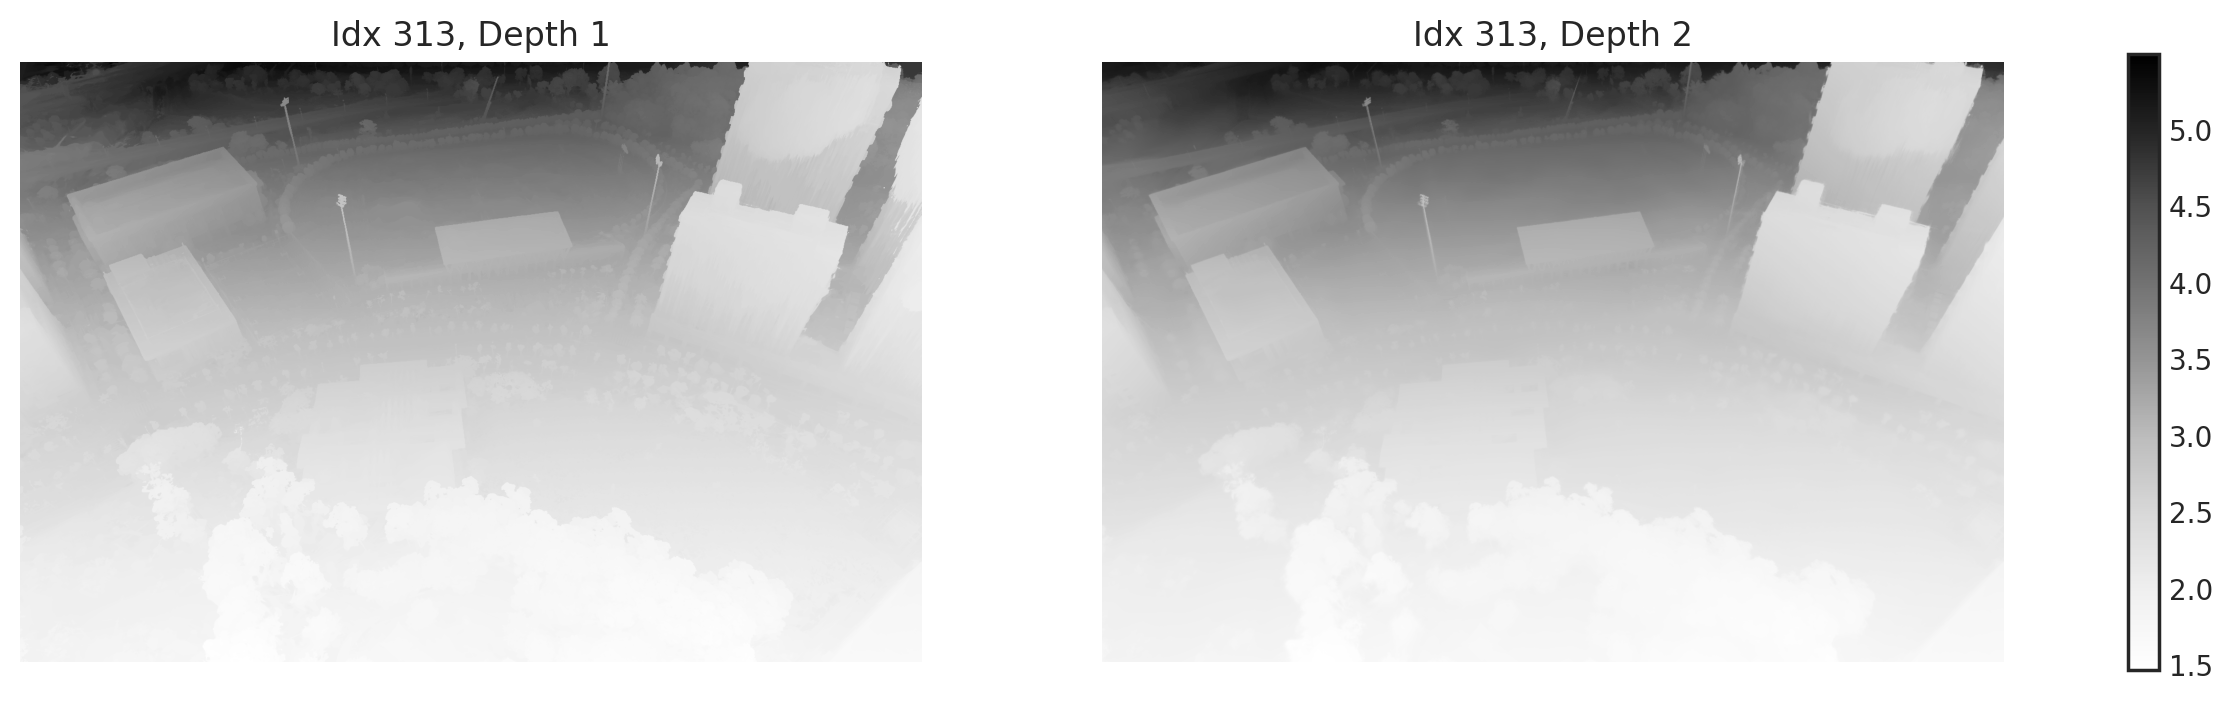

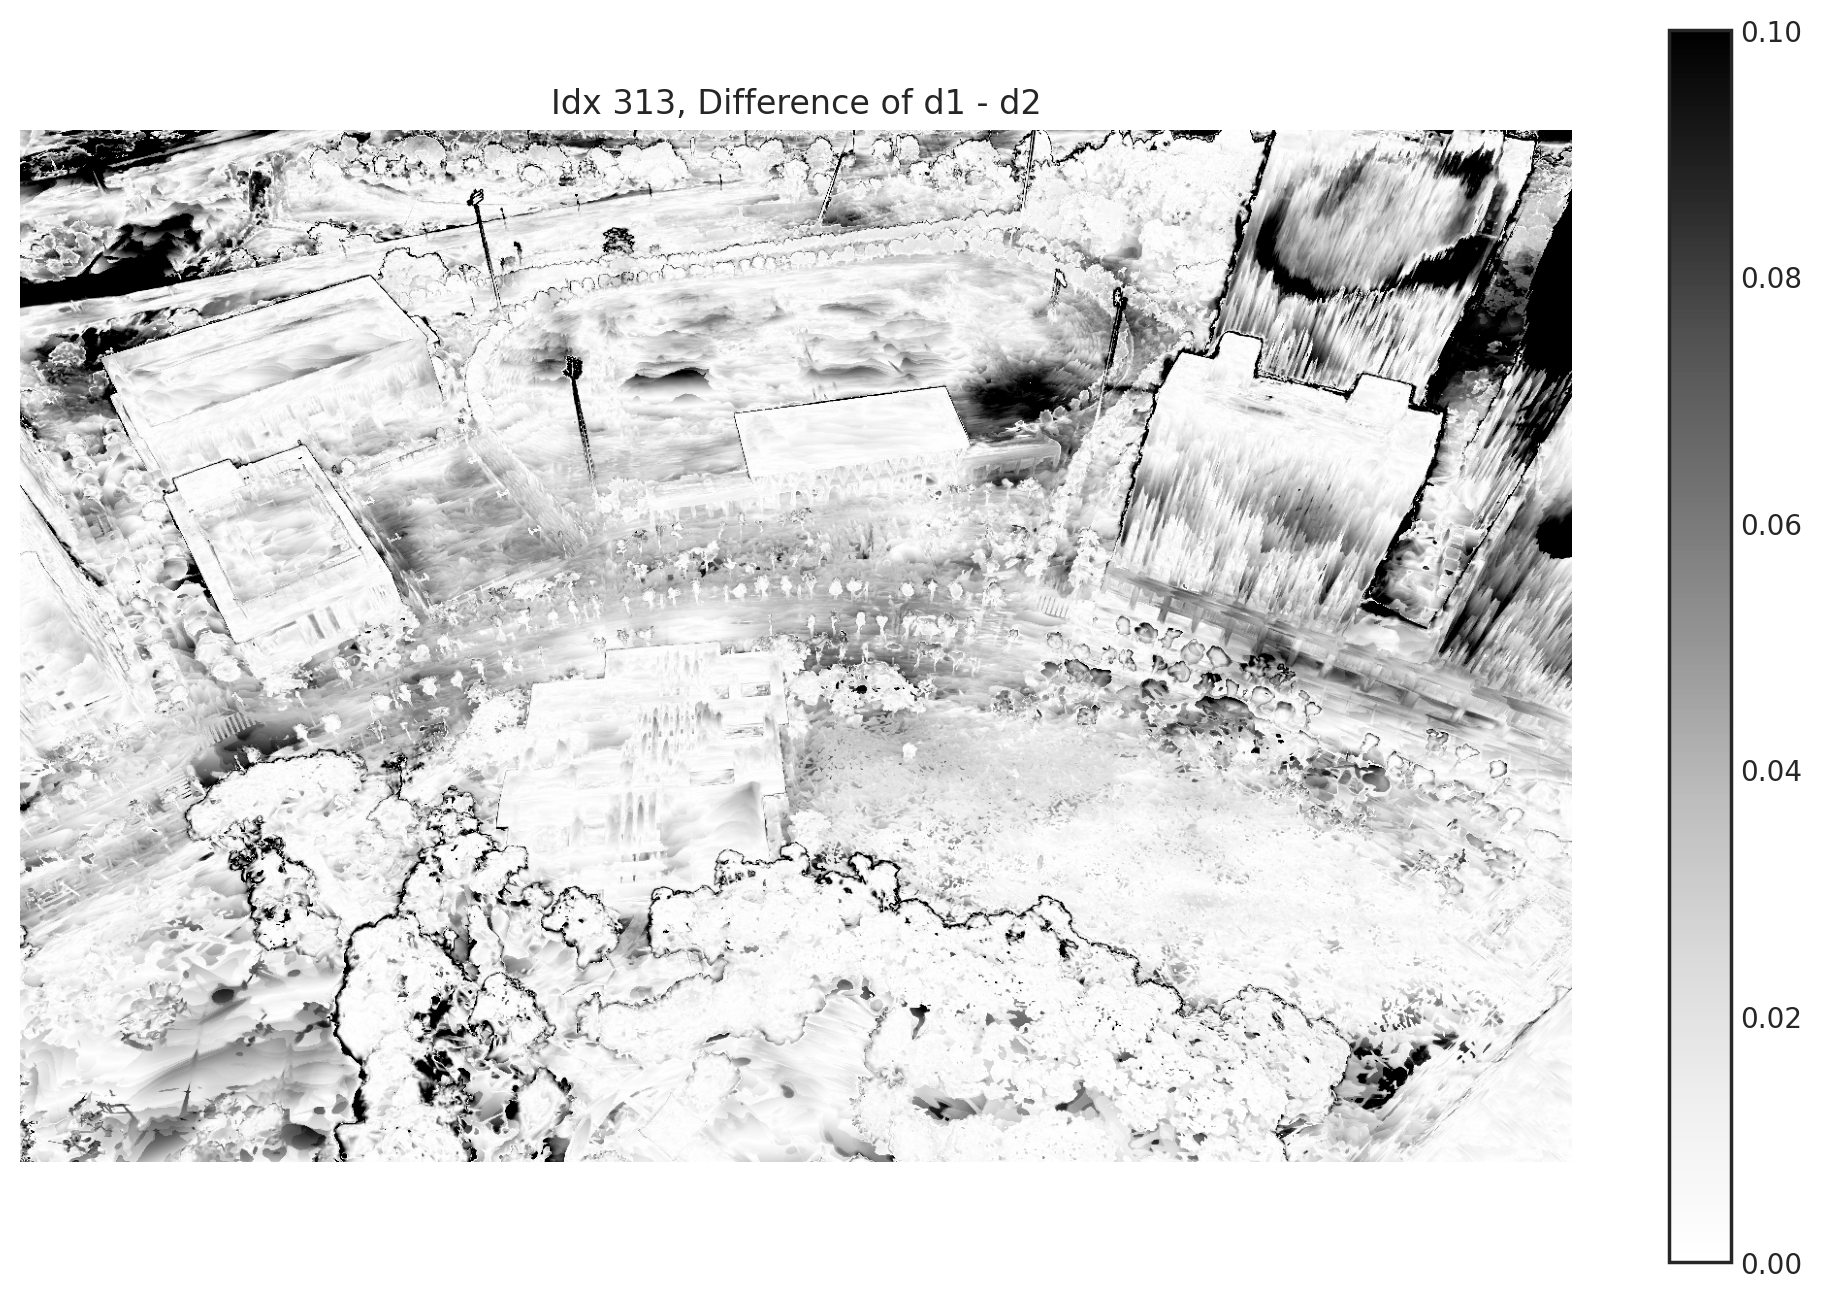

In [92]:
# Test image render
with torch.no_grad():
    # pick a camera
    idx = random.randint(0, len(dataparser_outputs.train_set.cameras) - 1)
    # idx = 27  # 120,
    camera = dataparser_outputs.train_set.cameras[idx].to_device("cuda")
    image_path = dataparser_outputs.train_set.image_paths[idx]
    gt = torch.tensor(plt.imread(image_path), dtype=torch.float, device="cuda").permute(2, 0, 1) / 255.0

    outputs_1 = renderer_1(camera, model_1, bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"))
    depth_1 = outputs_1['surf_depth'] if 'surf_depth' in outputs_1 else outputs_1['median_depth']
    outputs_2 = renderer_2(camera, model_2, bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"))
    depth_2 = outputs_2['surf_depth'] if 'surf_depth' in outputs_2 else outputs_2['median_depth']
    
    vmin = min(depth_1.min().item(), depth_2.min().item())
    vmax = max(depth_1.max().item(), depth_2.max().item())
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

print(f"Image {dataparser_outputs.train_set.image_names[idx]}")
print(f"depth1 from {load_from_1}")
print(f"depth2 from {load_from_2}")
plt.style.use('seaborn-v0_8-white')

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)
a = ax.imshow(depth_1.permute(1, 2, 0).cpu().numpy(), norm=norm)
b = bx.imshow(depth_2.permute(1, 2, 0).cpu().numpy(), norm=norm)
ax.set_title(f"Idx {idx}, Depth 1")
bx.set_title(f"Idx {idx}, Depth 2")
ax.axis('off')
bx.axis('off')
fig.colorbar(a, ax=[ax, bx], shrink=0.5)

plt.figure(figsize=(10, 8))
plt.imshow((depth_1 - depth_2).abs().clamp(0, 0.1).permute(1, 2, 0).cpu().numpy())
plt.colorbar(shrink=0.8)
plt.title(f"Idx {idx}, Difference of d1 - d2")
plt.axis('off')
plt.tight_layout()